In [3]:
%matplotlib inline
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy
import library.fit as ft

In [4]:
mm_genes = '../data/TARGET-OSTEO-TREE-Cluster-0-NO-MUSCLE/MultiModalGenes/'
exp_path = '../data/TARGET-OSTEO-TREE-Cluster-0-NO-MUSCLE.tsv'

In [5]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

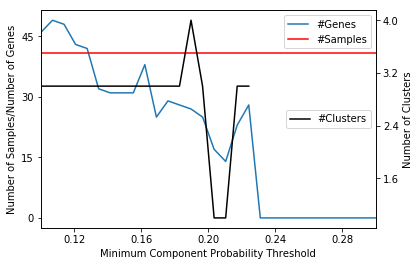

In [6]:
if True:

    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO',
                                     min_prob_range=np.linspace(0.1, 0.3, 30), 
                                     CPU=7,
                                     K=5).scan()
    
    scan

In [7]:
scan

,num_genesets,gs_terms,gs_term_genes,num_genes,num_clusters,num_samples
min_prob_filter,,,,,,
0.100000,5,muscle system process|muscle contraction|anter...,PTGS2|ACTA1|MYH14|ACTC1|DES|NEB|CLDN11|PCDHGB7...,46,3,41
0.106897,6,muscle system process|muscle contraction|anter...,PTGS2|ACTA1|MYH14|ACTC1|DES|NEB|CLDN11|PCDHGB7...,49,3,41
0.113793,5,muscle system process|anterograde trans-synapt...,PTGS2|SLC17A7|MYH14|ACTC1|DES|NEB|CLDN11|PCDHG...,48,3,41
0.120690,6,muscle contraction|striated muscle contraction...,CLDN11|MYH14|ACTC1|TNNT1|JPH1|PCDHGB7|NTRK2|S1...,43,3,41
0.127586,6,muscle contraction|muscle system process|stria...,CLDN11|MYH14|ACTC1|TNNT1|JPH1|PCDHGB7|PCDHGA12...,42,3,41
0.134483,4,regulation of system process|muscle contractio...,CLDN11|MYH14|ACTC1|DES|TNNT1|PCDHGB7|PCDHGA12|...,32,3,41
0.141379,5,regulation of system process|striated muscle c...,CLDN11|MYH14|ACTC1|DES|PCDHGB7|PCDHGA12|HAND2|...,31,3,41
0.148276,5,regulation of system process|striated muscle c...,CLDN11|MYH14|ACTC1|DES|PCDHGB7|PCDHGA12|HAND2|...,31,3,41
0.155172,5,regulation of system process|striated muscle c...,CLDN11|MYH14|ACTC1|DES|PCDHGB7|PCDHGA12|HAND2|...,31,3,41


In [15]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.217241,
                            gmt_path='GO')

In [16]:
genes = res.get_enriched_term_genes()

len(genes)

23

In [17]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

centering data


In [18]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

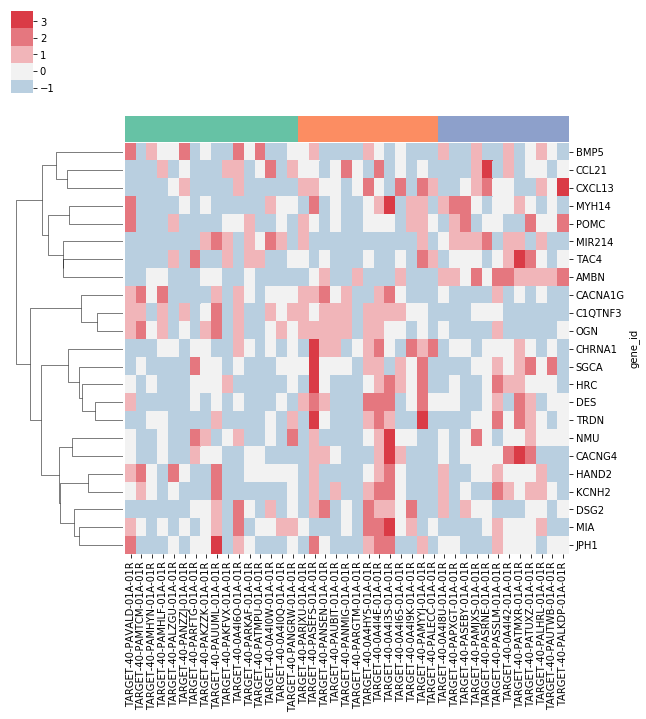

In [19]:
col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(genes).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

#ax.set_xticklabels([])
#ax.set_xticks([])
#ax.set_yticklabels([])
#ax.set_yticks([])

pth = '../img/target-th-cluster-0-expression-no-muscle-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/target-th-cluster-0-expression-no-muscle-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [20]:
fgsea = clus.get_cluster_features(exp, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [21]:
for key, values in fgsea.items():
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    #t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(20))

Key:  0 Empty DataFrame
Columns: [pathway, padj, NES]
Index: []
Key:  1                                               pathway      padj       NES
0   STRIATED MUSCLE CONTRACTION%WIKIPATHWAYS_20181...  0.013998  2.610022
1   BMAL1:CLOCK,NPAS2 ACTIVATES CIRCADIAN GENE EXP...  0.013998  2.586687
2   HALLMARK_MYOGENESIS%MSIGDB_C2%HALLMARK_MYOGENESIS  0.013766  2.506530
3   BIOCARTA_INTEGRIN_PATHWAY%MSIGDB_C2%BIOCARTA_I...  0.013981  2.491821
4             MUSCLE FILAMENT SLIDING%GOBP%GO:0030049  0.013998  2.469030
5       ACTIN-MYOSIN FILAMENT SLIDING%GOBP%GO:0033275  0.013998  2.469030
6                  MUSCLE CONTRACTION%GOBP%GO:0006936  0.013766  2.362968
7   POSITIVE REGULATION OF CANONICAL WNT SIGNALING...  0.013766  2.361982
8   CIRCADIAN CLOCK%REACTOME DATABASE ID RELEASE 6...  0.013766  2.337395
9    STRIATED MUSCLE CELL DEVELOPMENT%GOBP%GO:0055002  0.013969  2.333177
10  STRIATED MUSCLE CONTRACTION%REACTOME%R-HSA-390...  0.014014  2.328406
11  RESPONSE TO TRANSFORMING GROWTH FACT

In [16]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm',
              'SMN']
    
    if event in ['Censored', 'No event', 'None']:
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        #print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../../without-muscle/data/TARGET_OS_ClinicalData_Discovery_20181009.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=[x for x in exp.columns if x.startswith('TARGET')], 
                    columns=['OS', 'vital', 'EFS', 'event'])

for sample in exp.columns:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    event = get_event(clinical.loc[root, 'First Event'])
    
    surv.loc[sample, :] = [OS, vital, EFS, event]
    

for sample in surv.index.values:
    surv.loc[sample, 'cluster'] = int(assign.loc[sample, 1])
    
surv = surv.dropna()
    
surv.to_csv('../data/TARGET-osteo-THC0-survival-no-muscle.tsv', sep='\t')

surv

NULL
NULL
NULL


,OS,vital,EFS,event,cluster
TARGET-40-0A4HX8-01A-01R,1750,0,3050,0,3.0
TARGET-40-0A4HY5-01A-01R,290,1,218,1,4.0
TARGET-40-0A4I0Q-01A-01R,519,1,519,1,2.0
TARGET-40-0A4I0W-01A-01R,683,0,683,0,2.0
TARGET-40-0A4I3S-01A-01R,1844,0,1844,0,4.0
TARGET-40-0A4I42-01A-01R,619,1,351,1,1.0
TARGET-40-0A4I4O-01A-01R,627,1,235,1,3.0
TARGET-40-0A4I65-01A-01R,5840,0,1993,1,2.0
TARGET-40-0A4I6O-01A-01R,1906,1,484,1,2.0
TARGET-40-0A4I8U-01A-01R,983,0,983,0,1.0
